# Inferring a Station-Station Network Using NetworkX

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import sys

%load_ext autoreload
%autoreload 2
from utils import citibike_helpers
import numpy as np
import pandas as pd  #requirement comes with anaconda
import datetime 
from datetime import datetime as dt
import seaborn as sns
import operator
import networkx as nx
import community #requires separate install -  pip install python-louvain
import contextily as ctx
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
df = pd.read_csv('202401-citibike-tripdata/202401-citibike-tripdata_1.csv')
df['started_at'] = pd.to_datetime(df['started_at'])
df['ended_at'] = pd.to_datetime(df['ended_at'])
df['Trip Duration Minutes'] = (df['ended_at'] - df['started_at']).dt.total_seconds()/60
df['Trip Duration Minutes'] = df['Trip Duration Minutes'].astype(int)
subset_trips=df[(df['Trip Duration Minutes']>5) & (df['Trip Duration Minutes']<120)]
subset_trips.head(2)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,Trip Duration Minutes
1,AA7AB6D6E9F8D21B,classic_bike,2024-01-15 18:44:36,2024-01-15 19:19:46,E 16 St & Irving Pl,5938.11,Clermont Ave & Park Ave,4692.01,40.735367,-73.987974,40.695734,-73.971297,member,35
2,1830A6C4BA1E1A9D,classic_bike,2024-01-03 19:27:58,2024-01-03 19:58:42,E 16 St & Irving Pl,5938.11,Clermont Ave & Park Ave,4692.01,40.735367,-73.987974,40.695734,-73.971297,member,30


# Utils

In [4]:
def infer_weighted_station_station_network(df):
    dir_edges=dict()
    seen=list()
    for row in df.iterrows():
        st=row[1]['start_station_name']
        end=row[1]['end_station_name']
        tripduration=row[1]['Trip Duration Minutes']
        if not st in seen:
            seen.append(st)
            dir_edges[st]={end:tripduration}
        else:
            try:
                dir_edges[st][end]+=tripduration
            except KeyError:
                dir_edges[st][end]=tripduration 
    
    edges_with_weights=list()
    #weights=list()
    for st_stn in seen:  
        end_stns=list(dir_edges[st_stn].keys())   
        num_end_stations=len(end_stns)
        for end_stn in end_stns:
            norm_wt=dir_edges[st_stn][end_stn]/num_end_stations
            edges_with_weights.append({'edge':(st_stn,end_stn),'weight':norm_wt})
            
    return edges_with_weights

def create_subset_graph(edges_with_weights,thr=0.005,graphtype='Directed'):
    """
        Creates a directed graph 
    """
    #edges[:len(weights)*0.3]
    if graphtype=='Directed':
        g=nx.DiGraph() #Instantiate a Directed Graph Object from NetworkX.
    elif graphtype=='UnDirected':
        g=nx.Graph() #Instantiate an Undirected Graph Object from NetworkX.
    
    thr=thr #Get top 0.5% edges by weight.
    edges_with_weights_new=list(filter(lambda edg: edg['edge'][0]!=edg['edge'][1],
                                   sorted(edges_with_weights,reverse=True,
                                          key=operator.itemgetter('weight'))))[:int(len(edges_with_weights)*thr)]

    #[:len(edges_with_weights)*0.1]
    for edge_wt in edges_with_weights_new:
        g.add_edge(edge_wt['edge'][0],edge_wt['edge'][1],weight=edge_wt['weight'])
    
    return g

def plot_network(g,node_dist, nodecolor='g',nodesize=1200,nodealpha=0.6,edgecolor='k',\
                 edgealpha=0.2,figsize=(9,6),title=None,titlefontsize=20,savefig=False,\
                 filename=None,bipartite=False,bipartite_colors=None,nodelabels=None,
                 edgelabels=None):
    #pos=nx.spring_layout(g,iterations=200)
    pos=nx.spring_layout(g,k=node_dist,iterations=300)
    nodes=g.nodes()
    edges=g.edges()
    plt.figure(figsize=figsize)
    
    nx.draw_networkx_edges(g,pos=pos,edge_color=edgecolor,alpha=edgealpha)
    if bipartite and bipartite_colors!=None:
        bipartite_sets=nx.bipartite.sets(g)
        _nodecolor=[]
        for _set in bipartite_sets:
            _clr=bipartite_colors.pop()
            for node in _set:
                _nodecolor.append(_clr)

        nx.draw_networkx_nodes(g,pos=pos,node_color=_nodecolor,alpha=nodealpha,node_size=nodesize)
    else:
        nx.draw_networkx_nodes(g,pos=pos,node_color=nodecolor,alpha=nodealpha,node_size=nodesize)

    labels={}
    for idx,node in enumerate(g.nodes()):
        labels[node]=str(node)

    if nodelabels!=None:
        nx.draw_networkx_labels(g,pos,labels,font_size=16)
    if edgelabels!=None: #Assumed that it is a dict with edge tuple as the key and label as value.
        nx.draw_networkx_edge_labels(g,pos,edgelabels,font_size=12)
    plt.xticks([])
    plt.yticks([])
    if title!=None:
        plt.title(title,fontsize=titlefontsize)
    plt.show()

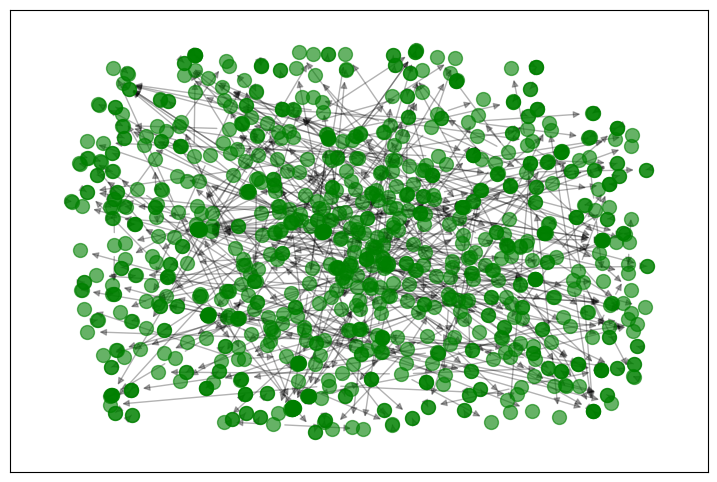

In [5]:
edges_with_weights=infer_weighted_station_station_network(subset_trips)
_thr=0.005
g=create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')
plot_network(g, node_dist=0.001, title="",edgealpha=0.3,nodesize=100)

start_station_name
W 21 St & 6 Ave       2939
8 Ave & W 31 St       2913
1 Ave & E 68 St       2764
W 31 St & 7 Ave       2598
E 33 St & 1 Ave       2562
Broadway & W 25 St    2403
Broadway & E 14 St    2153
Broadway & W 58 St    2145
E 17 St & Broadway    2070
E 47 St & Park Ave    2007
Name: count, dtype: int64


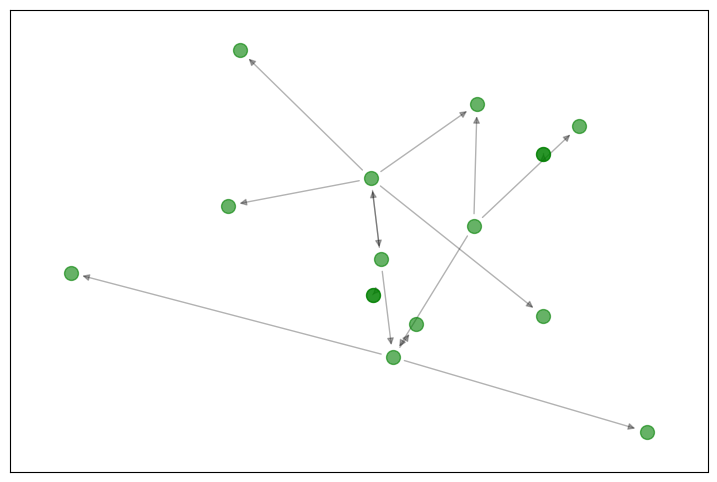

In [13]:
subset_trips_top10_nodes=subset_trips['start_station_name'].value_counts().head(10)
subset_trips_top10_edges=subset_trips[subset_trips['start_station_name'].isin(subset_trips_top10_nodes.index)]
print(subset_trips_top10_nodes)
edges_with_weights=infer_weighted_station_station_network(subset_trips_top10_edges)
_thr=0.005
g=create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')
plot_network(g, node_dist=0.001, title="",edgealpha=0.3,nodesize=100)


In [14]:
selected_trips = subset_trips_top10_edges.groupby('start_station_name').agg({'ride_id': 'count', 'start_lat': 'first', 'start_lng': 'first'}).reset_index()
selected_trips.columns = ['start_station_name', 'ride_count', 'start_lat', 'start_lng']
selected_trips

,start_station_name,ride_count,start_lat,start_lng
0,1 Ave & E 68 St,2764,40.764939,-73.958208
1,8 Ave & W 31 St,2913,40.750463,-73.994807
2,Broadway & E 14 St,2153,40.734546,-73.990741
3,Broadway & W 25 St,2403,40.742869,-73.989186
4,Broadway & W 58 St,2145,40.766666,-73.982515
5,E 17 St & Broadway,2070,40.737050,-73.990093
6,E 33 St & 1 Ave,2562,40.743560,-73.975094
7,E 47 St & Park Ave,2007,40.755103,-73.974987
8,W 21 St & 6 Ave,2939,40.741740,-73.994156
9,W 31 St & 7 Ave,2598,40.748828,-73.991291


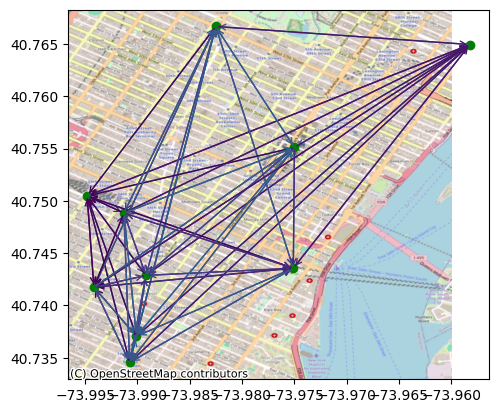

In [22]:
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=selected_trips['ride_count'].max())

fig, ax = plt.subplots()
ax.scatter(selected_trips['start_lng'], selected_trips['start_lat'], color='green')
for i, row in selected_trips.iterrows():
    for j, row2 in selected_trips.iterrows():
        if i != j:
            ax.annotate('', xy=(row2['start_lng'], row2['start_lat']), xytext=(row['start_lng'], row['start_lat']),
                        arrowprops=dict(arrowstyle='->', color=cmap(norm(row2['ride_count']))))

ctx.add_basemap(ax, crs="EPSG:4236" ,source=ctx.providers.OpenStreetMap.Mapnik)
plt.show()

## Strongly Connected Components

Number of Strongly Connected Components 914 
Sample Strongly Connected Components [['Yankee Ferry Terminal', 'Picnic Point', 'Soissons Landing'], ['W 190 St & St Nicholas Ave'], ['9 Ave & W 219 St']]


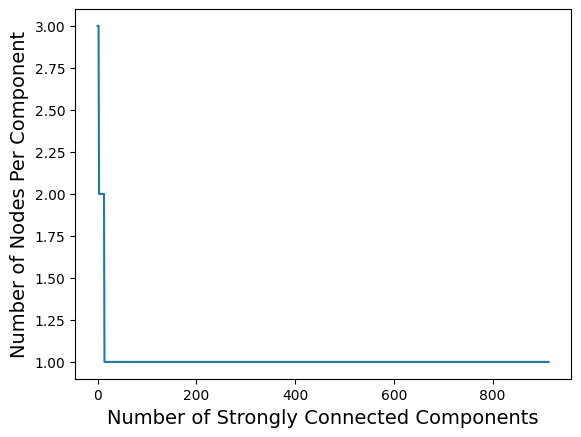

In [54]:
scc=[list(l) for l in nx.strongly_connected_components(g)]  #Strongly Connected Components
print("Number of Strongly Connected Components",len(scc),"\nSample Strongly Connected Components",scc[:3])
plt.plot(list(sorted(map(lambda x: len(x),scc),reverse=True)))
plt.xlabel("Number of Strongly Connected Components",fontsize=14)
plt.ylabel("Number of Nodes Per Component",fontsize=14)
plt.show()

## Weakly Connected Components

Number of Weakly Connected Components 114 
Sample Weakly Connected Components [['Yankee Ferry Terminal', 'Picnic Point', 'Soissons Landing'], ['W 190 St & St Nicholas Ave', '9 Ave & W 219 St'], ['Astoria Park S & Shore Blvd', 'Willoughby St & Fleet St', '27 St & Hunter St', 'George St & Wilson Ave', 'Riverside Dr & W 82 St', 'Ditmars Blvd & 102 St', '61 St & Borden Ave', '12 Ave & W 125 St', 'Nagle Ave & Ellwood St', 'Amsterdam Ave & W 73 St', '3 Ave & E Tremont Ave', 'Matthews Ct & Coney Island Ave', '58 St & Pier 4', 'Bainbridge Ave & E 193 St', 'Bulova Ave & Brooklyn Queens Expressway W', '59 St & 59 Rd', 'E 27 St & 1 Ave', 'St Felix Ave & 61 St', 'Judge St & Britton Ave', 'Church Ave & E 45 St', '42 Ave & 108 St', 'Sedgwick Ave & Giles Pl', 'W 52 St & 6 Ave', '60 Ave & Fresh Pond Rd', 'Bronx Park S & Bryant Ave', '58 St & 2 Ave', 'Riverside Dr & W 138 St', 'Ralph Ave & Fulton St', '3 Ave & Franklin Ave', 'Vyse Ave & E 181 St', 'Degraw St & 3 Ave', '3 Ave & Schermerhorn St', '104 St

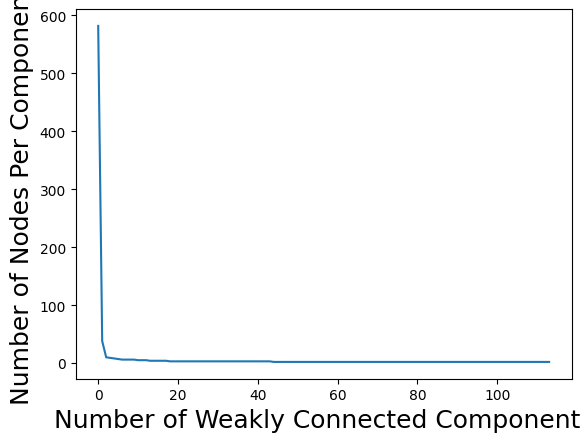

In [55]:
wcc=[list(l) for l in nx.weakly_connected_components(g)]  #Weakly Connected Components
print("Number of Weakly Connected Components",len(wcc),"\nSample Weakly Connected Components",wcc[:3])
plt.plot(list(sorted(map(lambda x: len(x),wcc),reverse=True)))
plt.xlabel("Number of Weakly Connected Components",fontsize=18)
plt.ylabel("Number of Nodes Per Component",fontsize=18)
plt.show()

In [56]:
def graph_summary(G):
    summary_str = f"Graph with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges\n"
    
    avg_degree = sum(dict(G.degree()).values())/G.number_of_nodes()
    summary_str += f"Average degree: {avg_degree:.2f}\n"
    return summary_str

## Connected Component

In [57]:
und_g = g.to_undirected()
sub_graphs = (und_g.subgraph(c).copy() for c in nx.connected_components(und_g))
print('number of connected components: ' + str(len([k for k in sub_graphs])))

number of connected components: 114


In [58]:
sub_graphs = (und_g.subgraph(c).copy() for c in nx.connected_components(und_g))
sub_graphs = [k for k in sub_graphs]

## Giant Connected Component

In [59]:
Gc = max(sub_graphs, key=len)
Gc=nx.convert_node_labels_to_integers(Gc)
Gc.name='GCC'
print(graph_summary(Gc))

Graph with 582 nodes and 641 edges
Average degree: 2.20



In [60]:
node_indegrees,node_outdegrees=citibike_helpers.get_indegree_and_outdegree(g)
sorted_indegrees=citibike_helpers.sort_by_degree(node_indegrees,reverse=True)
sorted_outdegrees=citibike_helpers.sort_by_degree(node_outdegrees,reverse=True)

print("Sample Indegree List",node_indegrees[:5],"\n")
print("Sorted In Decreasing Order of Indegrees",sorted_indegrees[:5],"\n")
print("Sample Outdegree List",node_outdegrees[:5],"\n")
print("Sorted In Decreasing Order of Outdegree",sorted_outdegrees[:5],"\n")

Sample Indegree List [('Yankee Ferry Terminal', 2), ('Soissons Landing', 2), ('Picnic Point', 2), ('9 Ave & W 219 St', 0), ('W 190 St & St Nicholas Ave', 1)] 

Sorted In Decreasing Order of Indegrees [('1 Ave & E 68 St', 19), ('7 Ave & Central Park South', 16), ('75 St & Roosevelt Ave', 15), ('Wards Meadow Comfort Station', 10), ('44 Dr & Jackson Ave', 9)] 

Sample Outdegree List [('Yankee Ferry Terminal', 2), ('Soissons Landing', 2), ('Picnic Point', 2), ('9 Ave & W 219 St', 1), ('W 190 St & St Nicholas Ave', 0)] 

Sorted In Decreasing Order of Outdegree [("Randall's Island - Field 10", 6), ('Dyckman St & Staff St', 6), ('Seaman Ave & Beak St', 5), ('57 St & 1 Ave', 5), ('Crotona Ave & E 179 St', 5)] 



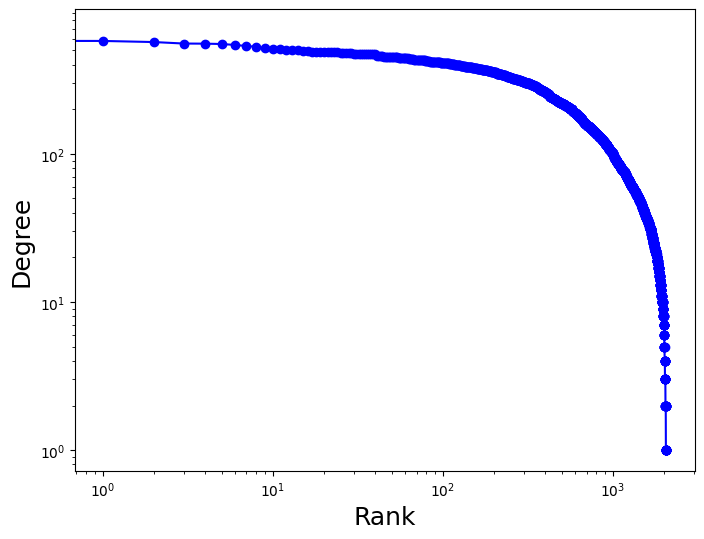

In [61]:
citibike_helpers.generate_degree_rank_plot(edges_with_weights)

In [62]:
#Create Minimal Subgraph
edges_with_weights=infer_weighted_station_station_network(subset_trips)
_thr=0.05
g=create_subset_graph(edges_with_weights,thr=_thr,graphtype='Directed')

In [63]:
pg_rank=sorted([l for l in nx.pagerank(g).items()],key=lambda x: x[1],reverse=True)
print("Top 10 Stations By Pagerank",pg_rank[:10])

Top 10 Stations By Pagerank [('1 Ave & E 68 St', 0.015990329036952397), ('E 47 St & Park Ave', 0.014449299253135494), ('W 31 St & 7 Ave', 0.013433640813130922), ('7 Ave & Central Park South', 0.012992724863643317), ('Broadway & W 58 St', 0.012504167523923637), ('W 41 St & 8 Ave', 0.011320272507562349), ('E 58 St & 3 Ave', 0.010762179688023824), ('8 Ave & W 31 St', 0.008612902149707027), ('W 21 St & 6 Ave', 0.00859577920918323), ('FDR Drive & E 35 St', 0.00843019313805711)]


In [64]:
hubs,authorities=nx.hits(g)
hubs=sorted([l for l in hubs.items()],key=lambda x: x[1],reverse=True)
authorities=sorted([l for l in authorities.items()],key=lambda x: x[1],reverse=True)
print("Top 10 Biggest Hubs",hubs[:10])
print("\nTop 10 Biggest Authorities",authorities[:10])

Top 10 Biggest Hubs [('Yankee Ferry Terminal', 0.658047836518574), ('Picnic Point', 0.33007195049558047), ('Soissons Landing', 0.011880212985845795), ('Faile St & Garrison Ave', 4.55197996712858e-17), ('47 Ave & 104 St', 1.0485810995706904e-17), ('Lenox Rd & E 43 St', 4.732614092808286e-18), ('Maurice Ave & 53 Dr', 3.3818986503901713e-18), ('Waterloo Pl & Crotona Park East', 1.721382718259663e-18), ('Sedgwick Ave & W Tremont Ave', 1.3905454204701545e-18), ('Kingsbridge Terrace & W 230 St', 1.3369302065109785e-18)]

Top 10 Biggest Authorities [('Soissons Landing', 0.9193078621260338), ('Picnic Point', 0.062389650917006344), ('Yankee Ferry Terminal', 0.018302486956961406), ('Prospect Ave & E 167 St', 1.5187921028125767e-16), ('97 St & 23 Ave', 3.437266337944252e-17), ('Bergen St & Vanderbilt Ave', 2.557965646842234e-17), ('Walton Ave & E 151 St', 1.9184742351316755e-17), ('Westchester Ave & Southern Blvd', 1.3589192498849368e-17), ('1 Ave & E 94 St', 1.278982823421117e-17), ('Broadway & 

<Axes: xlabel='Degree Distribution', ylabel='Density'>

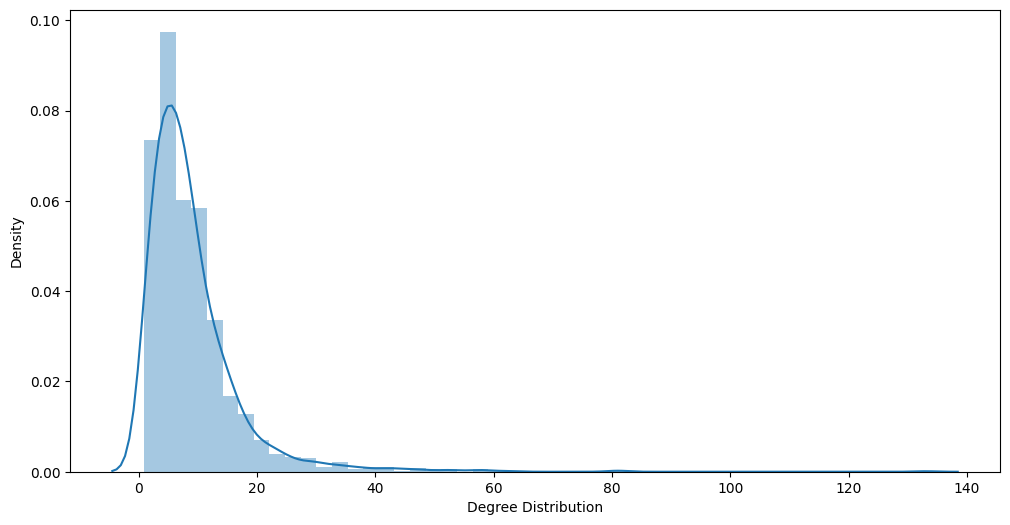

In [65]:
node_degrees = [item for item in dict(g.degree()).items()]
fig_dims = (12, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(pd.Series(np.array(node_degrees).T[1], name='Degree Distribution'), ax=ax)

## Clustering Coefficient

Average Clustering Coefficient 0.3702


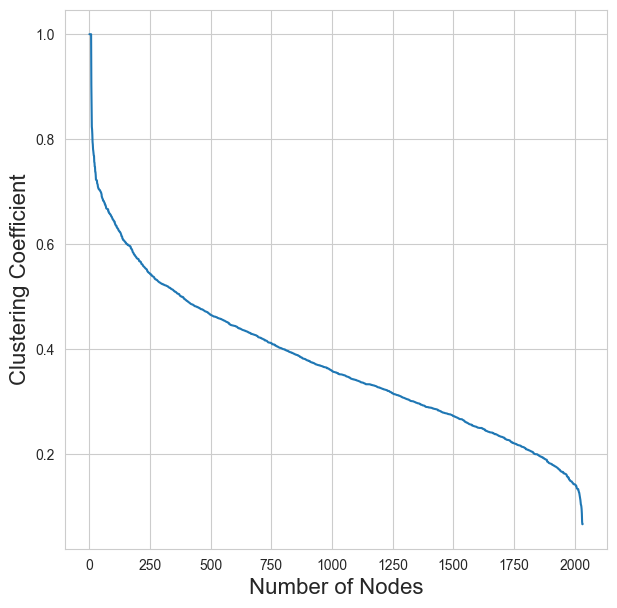

In [67]:
edges_with_weights=infer_weighted_station_station_network(subset_trips)
_thr=1.0
g=create_subset_graph(edges_with_weights,thr=_thr,graphtype='UnDirected')    
citibike_helpers.generate_clustering_coefficient_plot(g)
clust_coeff=nx.average_clustering(g)
print("Average Clustering Coefficient",round(clust_coeff,4))